# Analysis of a bias-free network

A bias-free network operates on its input by applying an adaptive linear transform (adaptive, because the transform is dependent on the input image). In this notebook, we analyze the properties of this transform using singular value decomposition.


In [47]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.patches as patches
import os
import torch
from skimage import io
from skimage.measure.simple_metrics import compare_psnr, compare_mse
import sys  
from utils import *
import time 

%matplotlib notebook

In [48]:
# Paths for data, pretrained models, and precomputed performance measures
pretrained_base = './pretrained/'
precomputed_base = './precomputed/'
data_base = 'data/'

# Datasets available in the data folder
train_folder_path = os.path.join(data_base, 'Train400/')
test_folder_path = os.path.join(data_base, 'Test/Set68/')
set12_path = os.path.join(data_base, 'Test/Set12/')
kodak_path = os.path.join(data_base, 'Test/Kodak23/') 

### Choose a model 

Note: we provide four pre-trained models. You can train and analyze any other model (and its bias-free counterpart) using the train script provided in the repository. 

In [49]:
# Choose a model (pre-trained options: 'dncnn', 'unet', 'rcnn', 'sdensenet')
model = 'dncnn' 

# Select the range of noise levels (stdev, relative to intensities in range [0,255]) 
# used during training (options are 0-10, 0-30, 0-55, 0-100).
l = 0   # lower bound of training range 
h = 100 # upper bound of training range

BF_CNN = load_model(os.path.join(pretrained_base, model, 'bias_free', str(l)+'-'+str(h)+'.pt'))

### Choose a clean image


<IPython.core.display.Javascript object>


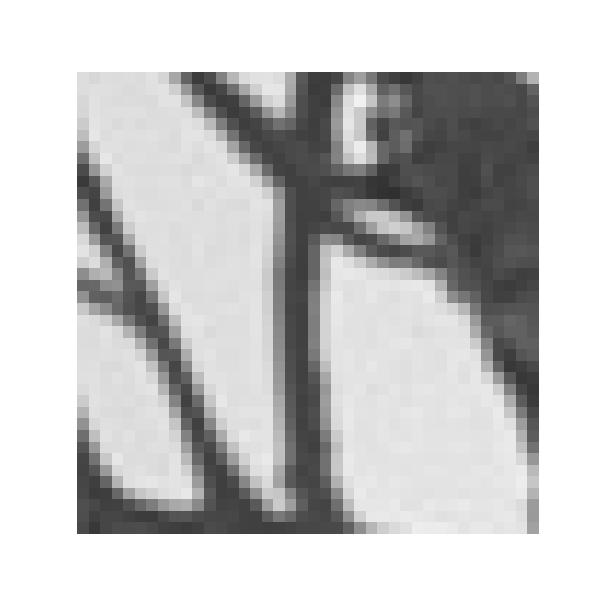

In [50]:
# choose a clean image (figure 4 in paper uses image_num=15)
image_num = 15
clean_im = single_image_loader(test_folder_path, image_num)

# Crop out a 40x40 patch (optional, helps for visibility.  Same values used for Figure 4 in paper).
clean_im = clean_im[100:140, 100:140]
dim1, dim2 = clean_im.shape
f , axs = plt.subplots(1,1 , figsize=(3,3))    
axs.imshow(clean_im, 'gray', vmin=0, vmax = 1)
axs.axis('off');


## Interpretation: Nonlinear adaptive filtering

Since the BF-CNN can be interpreted as applying an adaptive linear transform, each pixel in the denoised image is a weighted sum of input pixels. The weighting function is one row of the Jacobian, evaluated at the input image. Here, we examine this weighting function for selected output pixels, as shown in Figure 4 of the paper.

### Interactive visualization of adaptive filters

Note that all weighting functions sum to approximately one, and thus compute a local average. Their shapes vary substantially, and are adapted to the underlying image content. As the noise level increases, the spatial extent of the weight functions increases in order to average out the noise, while respecting boundaries between different regions in the image, which results in dramatically different functions for each pixel (i.e., non-convolutional).

<IPython.core.display.Javascript object>


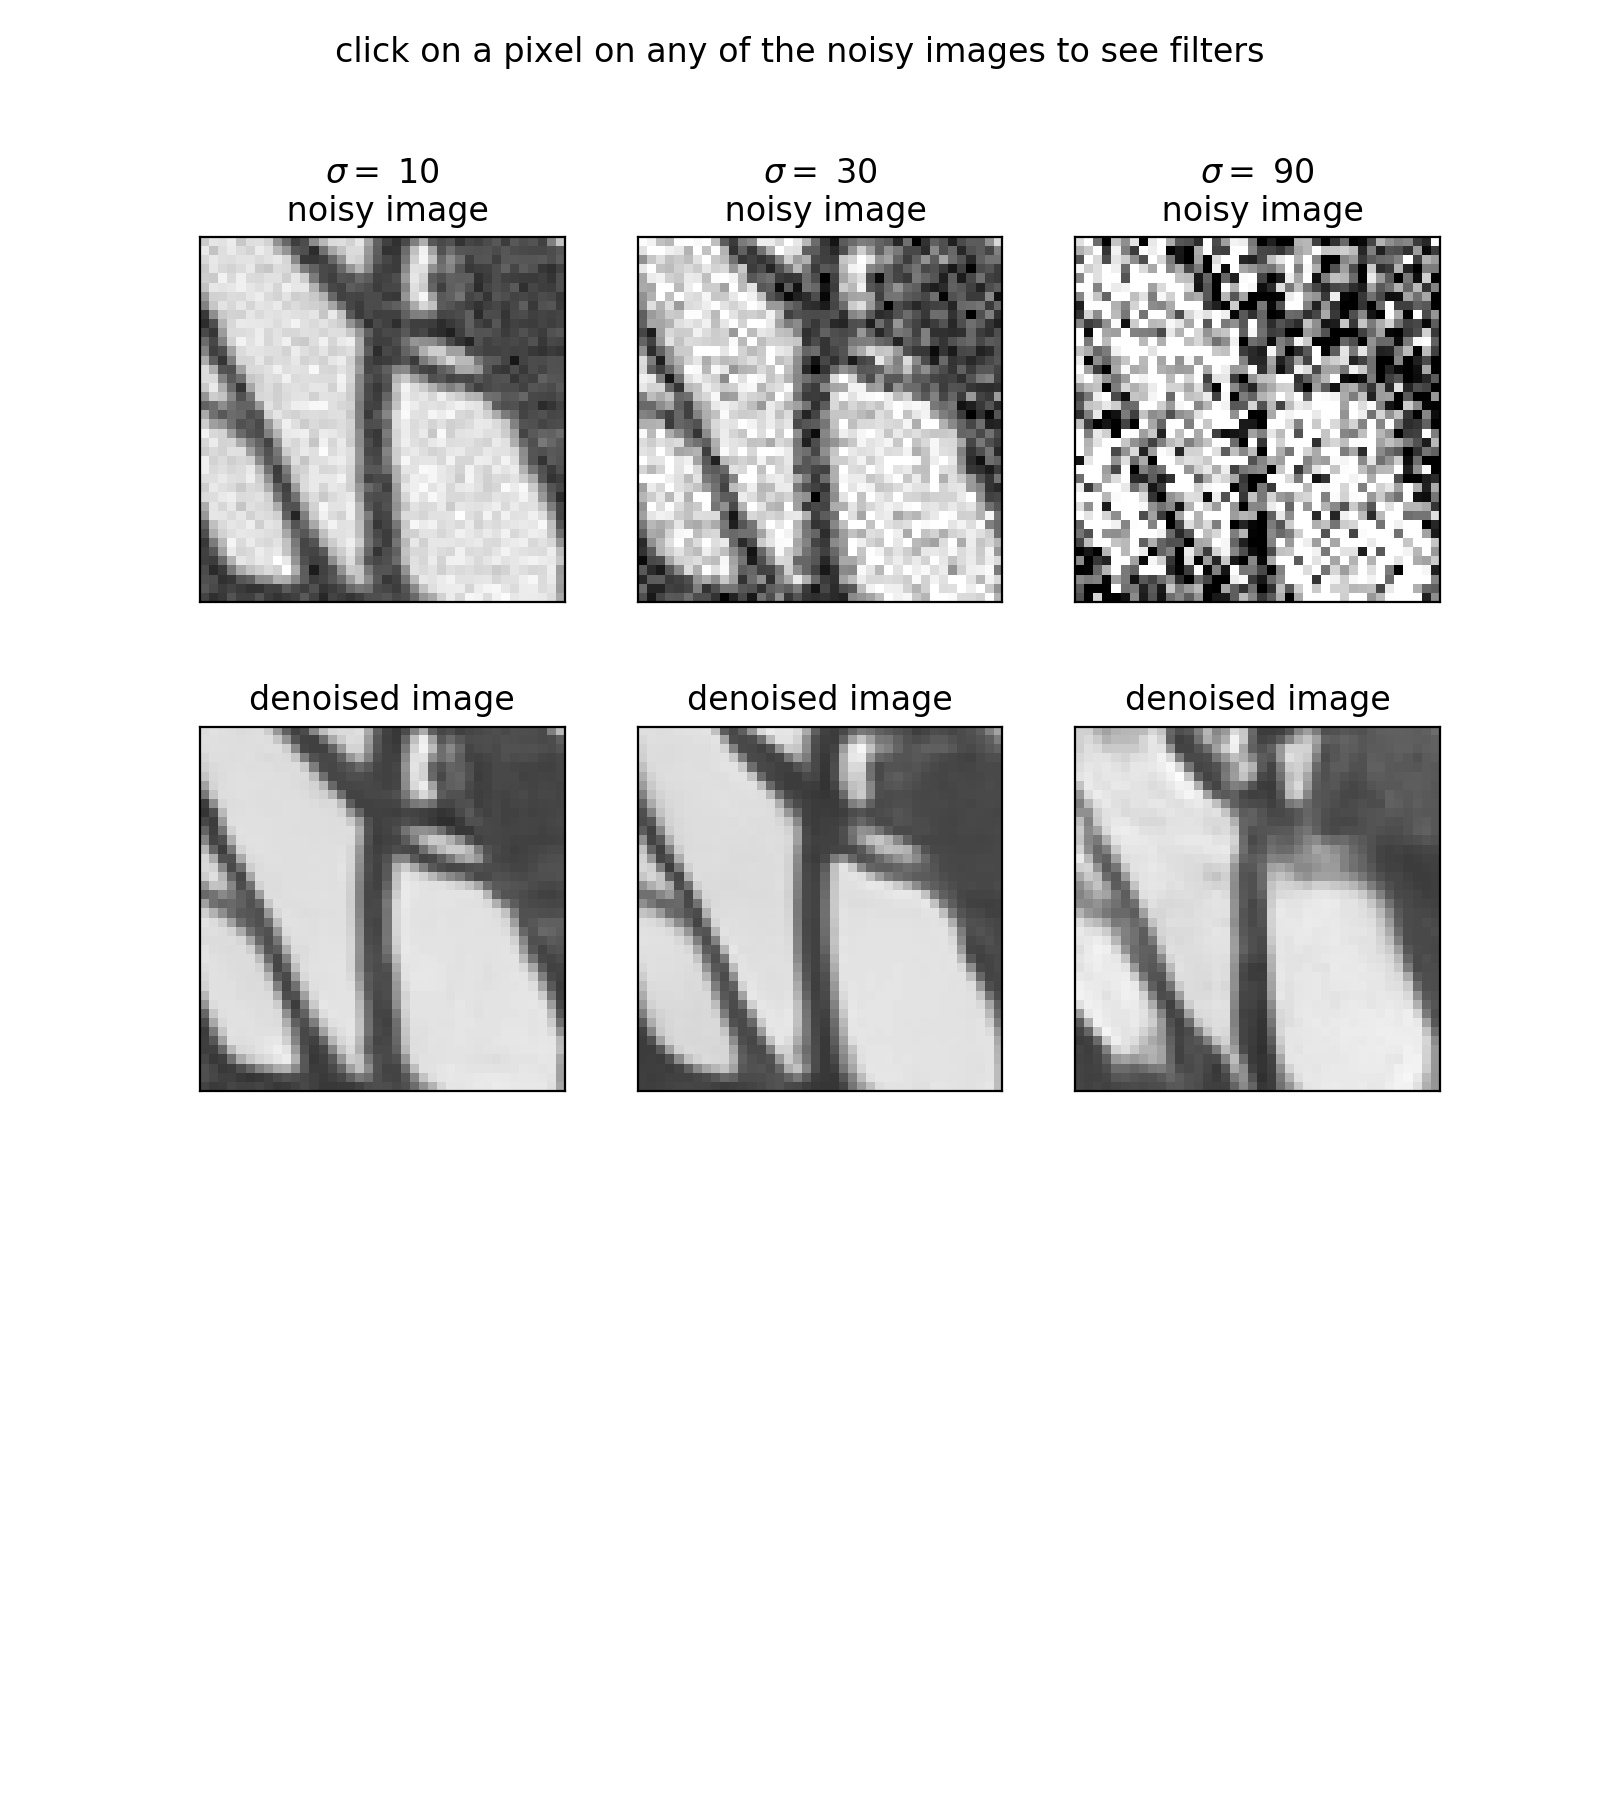

In [51]:
# Choose some noise levels to examine, relative to image intensities in range (0,255)
# Note: Figure 4 of paper uses [10, 30, 100].
noise_levels = [10, 30, 90] 

global residual_imgs, input_imgs
input_imgs = []
residual_imgs = []

%matplotlib notebook

fig = plt.figure(figsize = (8,9))
fig.suptitle('click on a pixel on any of the noisy images to see filters')
plt.axis('off')
ax_names=[]

for j in range(len(noise_levels)):
    # add noise
    noisy_im, _ = add_noise2(clean_im.reshape(1,dim1,dim2), noise_levels[j], 'S') 
    # plot noisy
    ax = fig.add_subplot(3,len(noise_levels),j+1)
    ax.imshow(noisy_im[0], 'gray', vmin = 0, vmax = 1)
    ax.tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
    ax.set_title(r'$\sigma = $ ' + str(noise_levels[j]) + '\n noisy image')
    ax_names.append(ax)  

    # denoise
    inp_test = torch.tensor(noisy_im.astype('float32'),requires_grad=True).unsqueeze(1)
    input_imgs.append(inp_test)
    residual= BF_CNN(inp_test)
    residual_imgs.append(residual)
    denoised = residual.squeeze(0).squeeze(0).data.numpy()
    
    # plot denoised
    ax = fig.add_subplot(3,len(noise_levels),j+len(noise_levels)+1)
    ax.imshow(denoised, 'gray', vmin = 0, vmax = 1)
    ax.tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
    ax.set_title( 'denoised image')    
    
global last_pa 
last_pa = []

ix, iy = 0, 0
def onclick(event):

    global ix, iy
    ix, iy = int(event.xdata), int(event.ydata)
    
    # remove previous pixel marker
    if len(last_pa) != 0:       
        for i in range(len(last_pa)):
            last_pa[i].set_visible(False)         
    
    for j in range(len(noise_levels)):
        ax = fig.add_subplot(fig.add_subplot(3,len(noise_levels),j+len(noise_levels)*2+1))
        filt = torch.autograd.grad(residual_imgs[j][0,0,iy,ix], input_imgs[j], retain_graph=True)[0][0,0].data.numpy() 
        limit =  max(np.abs(np.min( filt)), np.abs(np.max( filt)))
        ax.imshow(filt, 'RdGy', vmin= -limit, vmax = limit)
        ax.set_title('adaptive filter \n sum = ' + str( np.round(np.sum(filt),2)))
        ax.tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
        pa = patches.Rectangle((ix-.5,iy-.5), width=1, height=1,edgecolor = [1,0,0], angle=0.0, facecolor='red', lw=1)
        ax_names[j].add_patch(pa)
        last_pa.append(pa)
        
cid = fig.canvas.mpl_connect('button_press_event', onclick);


In [22]:
# exit the interactive mode
f.canvas.mpl_disconnect(cid)


## Interpretation: Projection onto an adaptive signal subspace

We can study the effect of the linear transformation, A, by looking into its column space. A singular value decomposition of A, reveals that 1) most singular values are  close to zero, implying that the network is discarding all but a very low-dimensional portion of the input image, and 2) left and right singular vectors of the signal subspace are nearly identical. This means that we can interpret the action of the network as projecting the noisy signal onto a low-dimensional subspace.


### Compute SVD of Jacobian (adaptive linear transform) of denoiser


In [52]:
# Compute the Jacobian, evaluated at a noisy version of the clean image selected above. 
# WARNING: slow computation! For a 40x40 patch, it can take between 1 and 2 minutes. 

noisy_im = add_noise2(clean_im.reshape(1,dim1,dim2), 90, 'S')[0][0] 

start_time_total = time.time()
A = calc_jacobian(noisy_im,BF_CNN)
print("---- Jacobian computation time --- %s seconds ---" % (time.time() - start_time_total))


---- Jacobian computation time --- 52.0781512260437 seconds ---


In [53]:
# Compute SVD of Jacobian
U , S, V = np.linalg.svd( A)


### Plot singular values

Note that most singular values are close to zero, suggesting
the denoiser is eliminating many dimensions.


<IPython.core.display.Javascript object>


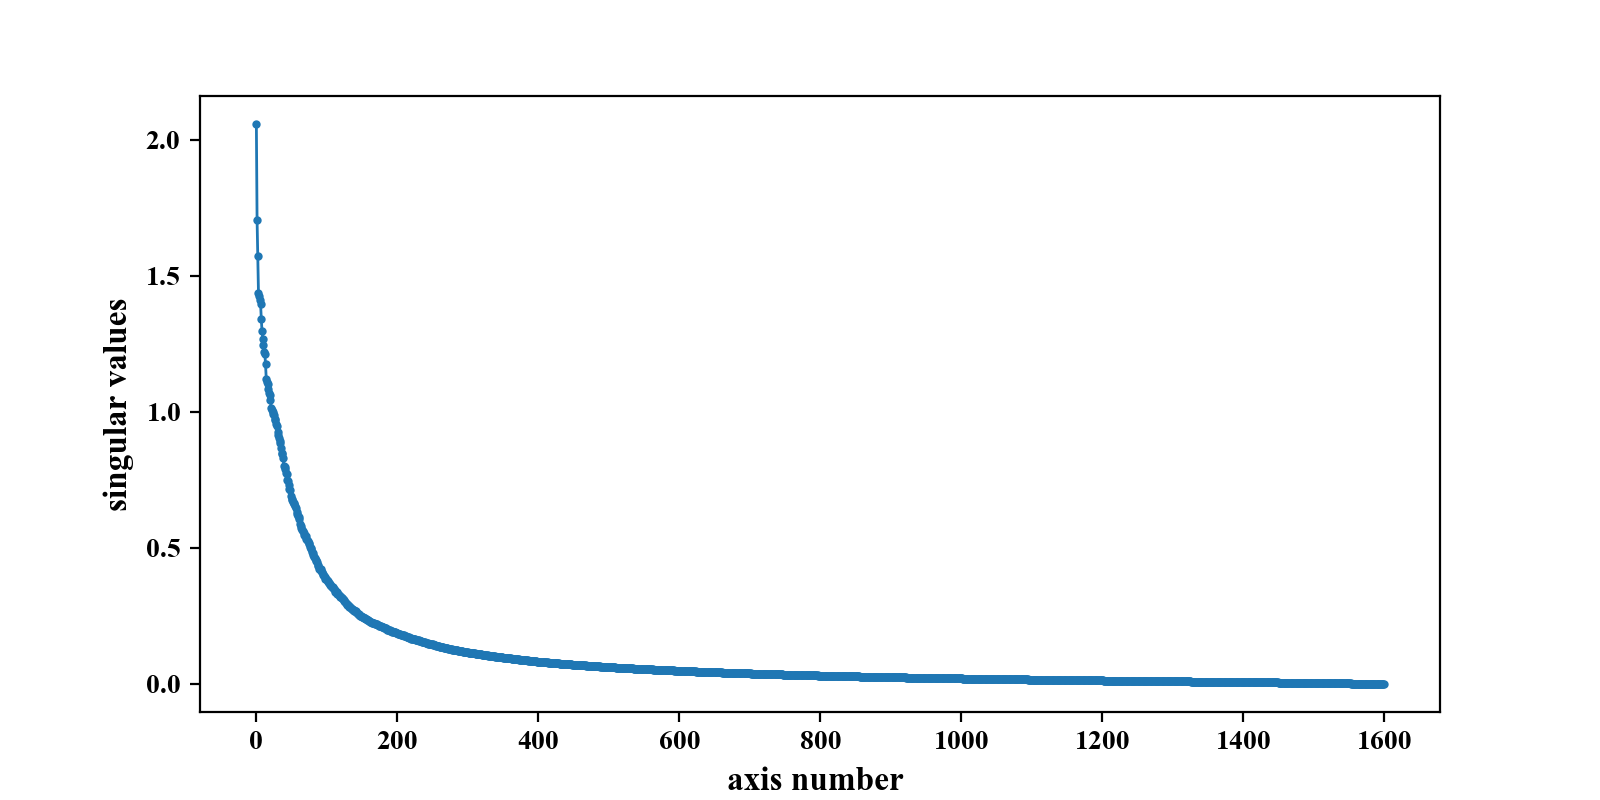

In [54]:
# Plot the singular values against the axis number. 
f, ax = plt.subplots(1,1,figsize = (8,4))

ax.set_xlabel('axis number ', fontsize = 12, fontname= 'Times New Roman')
ax.set_ylabel('singular values', fontsize = 12, fontname= 'Times New Roman')   

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10) 
    tick.label.set_fontname("Times New Roman")

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10) 
    tick.label.set_fontname("Times New Roman")
    
ax.plot(S, '-o', alpha = 1, markersize = 2,linewidth=1);


### Visualize some example singular vectors with large singular values

These are 'features' of the input image that are preserved by the denoiser.

<IPython.core.display.Javascript object>


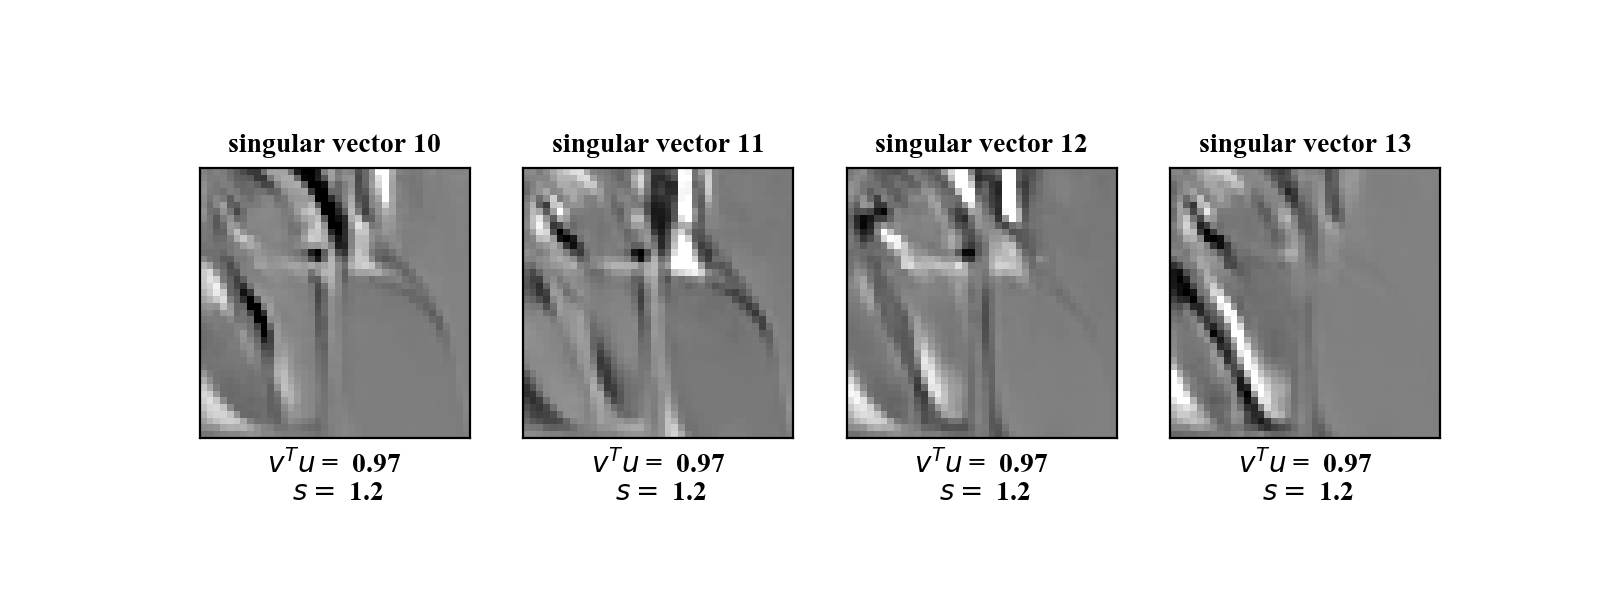

In [55]:
# Show some example singular vectors with large singular values
sing_vect_n = [10,11,12,13] # indices of the singular vectors for visualization 

N = dim1*dim2 # dimensionality of the space

limit =  max(np.abs(np.min( U[:,sing_vect_n])), np.abs(np.max(U[:,sing_vect_n])))
f , axs = plt.subplots(1,len(sing_vect_n) , figsize=(8,3))    
plt.subplots_adjust()
for i in range(len(sing_vect_n)):
    u = U[:,sing_vect_n[i]]
    v = V[sing_vect_n[i],:]
    axs[i].imshow(u.reshape(dim1,dim2), 'gray', vmin=-limit/2, vmax = limit/2)
    axs[i].set_title('singular vector '+str(sing_vect_n[i]), fontsize = 10, fontname= 'Times New Roman')
    axs[i].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
    axs[i].set_xlabel(r'$v^Tu$ =  '+str(np.round( np.dot(u,v) ,2))+ '\n $s =$ '+str(np.round(S[sing_vect_n[i]],1)),
                      fontsize = 10, fontname= 'Times New Roman');

### Visualize some example singular vectors with small singular values

These are 'features' of the input image that are discarded by the denoiser.

<IPython.core.display.Javascript object>


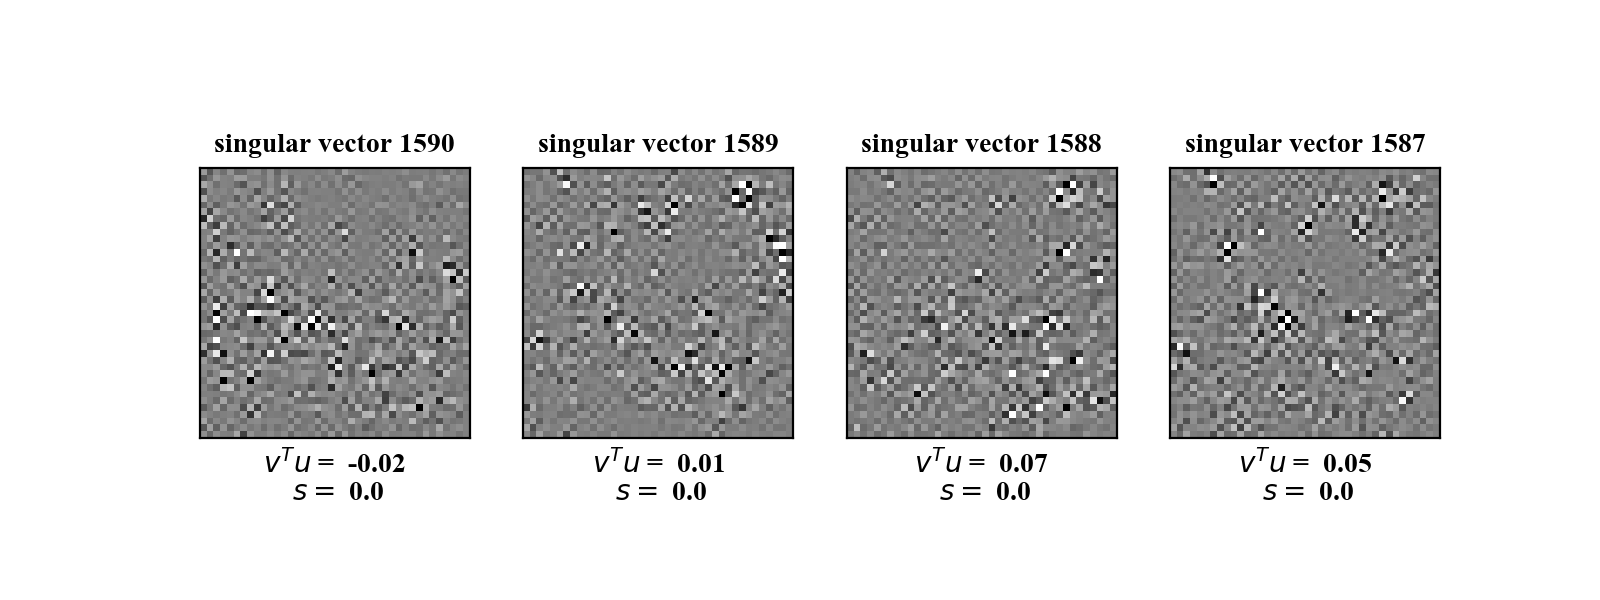

In [56]:
# Show some example singular vectors with small singular values
sing_vect_n = [N-10,N-11,N-12,N-13] # indices of the singular vectors for visualization 

limit =  max(np.abs(np.min( U[:,sing_vect_n])), np.abs(np.max(U[:,sing_vect_n])))
f , axs = plt.subplots(1,len(sing_vect_n) , figsize=(8,3))    
plt.subplots_adjust()
for i in range(len(sing_vect_n)):
    u = U[:,sing_vect_n[i]]
    v = V[sing_vect_n[i],:]
    axs[i].imshow(u.reshape(dim1,dim2), 'gray', vmin=-limit/2, vmax = limit/2)
    axs[i].set_title('singular vector '+str(sing_vect_n[i]), fontsize = 10, fontname= 'Times New Roman')
    axs[i].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
    axs[i].set_xlabel(r'$v^Tu$ =  '+str(np.round( np.dot(u,v) ,2))+ '\n $s =$ '+str(np.round(S[sing_vect_n[i]],1)),
                      fontsize = 10, fontname= 'Times New Roman');

### Left and right singular vectors with significant singular values are nearly identical


<IPython.core.display.Javascript object>


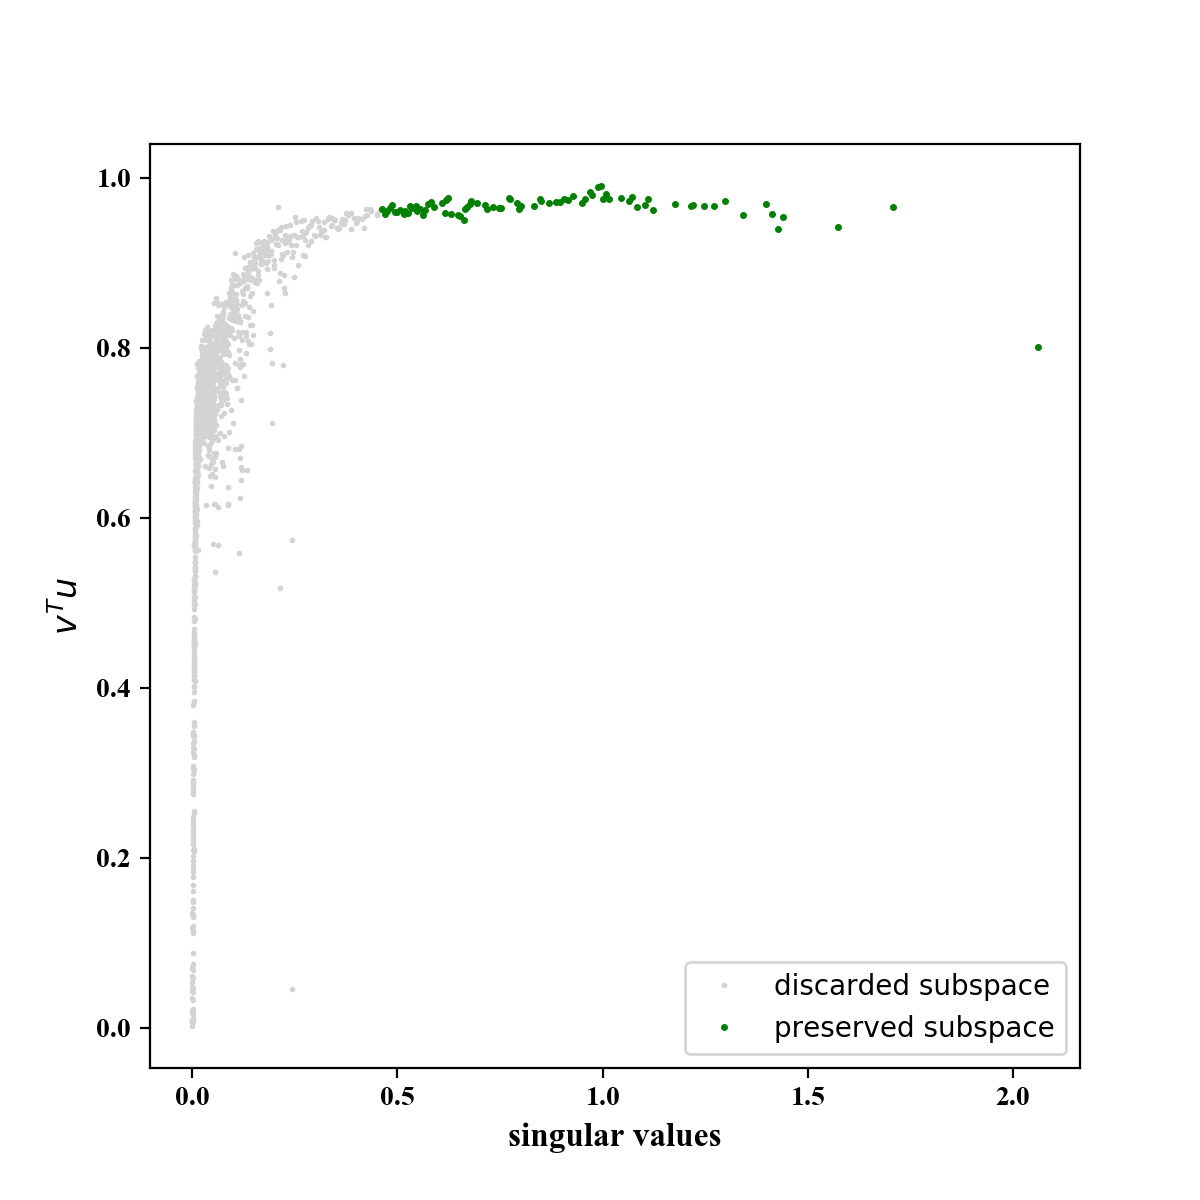

In [57]:
# Compute dot products of left and right singular vectors (u.v=1). 
subspace_dim = int(np.sum((S)**2))
uvdots = []
for j in range(N):
    v = V[j,:]
    u = U[:,j]
    uvdots.append(abs(np.dot(v,u)))

# Plot dot products as a function of associated singular value
f, ax = plt.subplots(1,1,figsize = (6,6))
ax.plot(S, uvdots, '.', color = 'lightgray', markersize=2 , label='discarded subspace')       
ax.plot(S[0:subspace_dim], uvdots[0:subspace_dim], '.',markersize=3,color='green',alpha=1, label = 'preserved subspace')     
ax.set_ylabel(r'${v}^T{u} $', fontsize = 12, fontname= 'Times New Roman')
ax.set_xlabel('singular values', fontsize = 12, fontname= 'Times New Roman')   
plt.legend()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10) 
    tick.label.set_fontname("Times New Roman")
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10) 
    tick.label.set_fontname("Times New Roman");